# **0. 준비단계**

## 0.1. 모듈 설치

In [ ]:
# ! pip install konlpy
# ! pip install tensorflow

## 0.2. 패키지 IMPORT

In [46]:
import os
import re
import json
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
# from konlpy.tag import Okt

from tensorflow.keras import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate, LSTM, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

## 0.3. 구글 드라이브 MOUNT

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/3조_XXXX/04. 기타자료/data/'
data_path = '/content/drive/MyDrive/Colab Notebooks/3조_XXXX/04. 기타자료/data/lstm_test/'

# **1. 모델 데이터 불러오기**

## **Settings**

In [ ]:
# input
model_num = 7       # MODEL 1 ~ 7
model_type = 5      # MODEL TYPE 1: simple | 2: Dropout | 3: Batch Normalization | 4: Bi-LSTM
p = 1               # number of categories(2, 3, 4)

save_num = f'{model_num}-{model_type}'

if p == 1:
    activation = 'linear'
    loss_function = 'mean_squared_error'
    metric = 'mse'
else:
    activation = 'softmax'
    loss_function = 'categorical_crossentropy'
    metric = 'accuracy'

## 1.1. 학습용 데이터 불러오기

In [ ]:
X = np.load(data_path + f'input_data{model_num}.npy')
Y = np.load(data_path + f'label_data{model_num}.npy')

In [ ]:
X

array([[  0.,   0.,   0., ..., 311.,   3.,  10.],
       [  0.,   0.,   0., ...,  17., 311.,  10.],
       [  0.,   0.,   0., ..., 449.,   8.,  52.],
       ...,
       [  0.,   0.,   0., ..., 217.,  58., 570.],
       [  0.,   0.,   0., ...,   6.,  20., 136.],
       [  0.,   0.,   0., ...,  32.,   6.,  27.]])

In [ ]:
Y

array([1., 1., 1., ..., 1., 1., 3.])

## 1.2. 학습 데이터, 검증 데이터, 테스트 데이터 분리

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=111)

In [ ]:
# 어떻게 분배되었는가?
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([1., 2., 3.]), array([69242,  6873, 14016]))
(array([1., 2., 3.]), array([17261,  1772,  3500]))


In [ ]:
# one-hot encoding
if p != 1:
    y_train = to_categorical(y_train, p)
    y_test = to_categorical(y_test, p)

In [ ]:
print(f'X: {X.shape}, Y: {Y.shape}')
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}')

X: (112664, 62), Y: (112664,)
x_train: (90131, 62), y_train: (90131,), x_test: (22533, 62), y_test: (22533,)


In [ ]:
traintest_data = {'x_train':x_train,
                  'y_train':y_train,
                  'x_test':x_test,
                  'y_test':y_test}
with open(data_path + f'traintest_data{save_num}.pkl', 'wb') as f:
    pickle.dump(traintest_data, f)

# **2. LSTM 모델 생성**

## 2.1. 하이퍼 파라미터 정의

In [55]:
configuration = json.load(open(data_path + f'data_configs{model_num}.json','r'))

MAX_SEQ_LEN = configuration['MAX_SEQ_LEN']

VOCAB_SIZE = configuration['vocab_size']

EMB_SIZE = 128

EPOCHS = 1000

hidden_units = 128

## 2.2. 모델 정의

In [56]:
if model_type == 1:
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(VOCAB_SIZE, EMB_SIZE))
    model_LSTM.add(LSTM(hidden_units))
    model_LSTM.add(Dense(p, activation=f'{activation}'))
    model_LSTM.compile(loss=f'{loss_function}', optimizer=Adam(learning_rate=5e-5), metrics=[f'{metric}'])
elif model_type == 2:
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(VOCAB_SIZE, EMB_SIZE))
    model_LSTM.add(LSTM(hidden_units, dropout=0.5))
    model_LSTM.add(Dense(p, activation=f'{activation}'))
    model_LSTM.compile(loss=f'{loss_function}', optimizer=Adam(learning_rate=5e-5), metrics=[f'{metric}'])  
elif model_type == 3:
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(VOCAB_SIZE, EMB_SIZE))
    model_LSTM.add(LSTM(hidden_units, return_sequences=False))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dense(p, activation=f'{activation}'))
    model_LSTM.compile(loss=f'{loss_function}', optimizer=Adam(learning_rate=5e-5), metrics=[f'{metric}']) 
elif model_type == 4:
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(VOCAB_SIZE, EMB_SIZE))
    model_LSTM.add(LSTM(hidden_units, dropout = 0.5, return_sequences=False))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dense(p, activation=f'{activation}'))
    model_LSTM.compile(loss=f'{loss_function}', optimizer=Adam(learning_rate=5e-5), metrics=[f'{metric}']) 
elif model_type == 5:
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(VOCAB_SIZE, EMB_SIZE))
    model_LSTM.add(Bidirectional(LSTM(hidden_units, dropout=0.5, return_sequences=False)))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dense(p, activation=f'{activation}'))
    model_LSTM.compile(loss=f'{loss_function}', optimizer=Adam(learning_rate=5e-5), metrics=[f'{metric}']) 

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         12800000  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 13,064,449
Trainable params: 13,063,937
Non-trainable params: 512
_________________________________________________________________


# **3. 모델 학습**

## 3.1. Early Stopping, Model Checkpoint

### 3.1.1. Early Stopping
**validation_loss**가 더 이상 갱신되지 않으면 멈추기로 했다. (과적합 방지)

In [57]:
es = EarlyStopping(monitor='val_loss', patience=3)

### 3.1.2. Model Checkpoint
가장 적합한 모델을 저장하기 위해 Checkpoint를 도입했다.<br>
구글 드라이브 용량 문제로 인해 **Prev_Best_Model.hdf5**로 이름을 통일해 갱신될때마다 덮어씌우기로 했다.

In [58]:
svm = ModelCheckpoint(filepath=data_path + f'/Prev_Best_LSTM_Model{save_num}.hdf5', verbose=1, save_best_only=True)

## 3.2. 모델 학습
어지간해서는 120 에포크 언저리에서 끝나게 된다.<br>
**Colab Pro GPU**를 사용하면 에포크당 걸리는 시간은 110초 정도로, **3시간 40분 정도** 돌리면 결과값이 나온다.

In [59]:
history = model_LSTM.fit(x_train, y_train, validation_split=0.25, batch_size=32, epochs=EPOCHS, verbose=1, callbacks=[es, svm])

Epoch 1/1000
2112/2113 [============================>.] - ETA: 0s - loss: 0.8893 - mse: 0.8893
Epoch 1: val_loss improved from inf to 0.42976, saving model to /content/drive/MyDrive/Colab Notebooks/3조_XXXX/04. 기타자료/data/lstm_test/Prev_Best_LSTM_Model7-5.hdf5
2113/2113 [==============================] - 51s 22ms/step - loss: 0.8895 - mse: 0.8895 - val_loss: 0.4298 - val_mse: 0.4298
Epoch 2/1000
2112/2113 [============================>.] - ETA: 0s - loss: 0.4025 - mse: 0.4025
Epoch 2: val_loss improved from 0.42976 to 0.37555, saving model to /content/drive/MyDrive/Colab Notebooks/3조_XXXX/04. 기타자료/data/lstm_test/Prev_Best_LSTM_Model7-5.hdf5
2113/2113 [==============================] - 45s 21ms/step - loss: 0.4025 - mse: 0.4025 - val_loss: 0.3756 - val_mse: 0.3756
Epoch 3/1000
2111/2113 [============================>.] - ETA: 0s - loss: 0.3670 - mse: 0.3670
Epoch 3: val_loss improved from 0.37555 to 0.36363, saving model to /content/drive/MyDrive/Colab Notebooks/3조_XXXX/04. 기ᄐ

In [60]:
# history 저장 
with open(data_path + f'history{save_num}.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## 3.3. 손실, 정확도 지표 확인

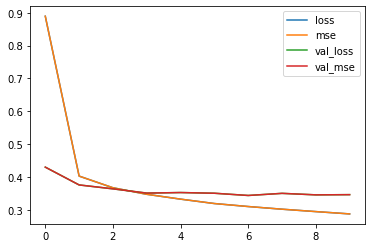

In [61]:
df_history = pd.DataFrame(history.history)
df_history.plot()

## 3.4. 테스트 세트를 이용한 모델 평가

In [62]:
loss, accuracy = model_LSTM.evaluate(x_test, y_test, verbose=1)
print(f'손실량: {loss}%, 정확도: {accuracy}%')

705/705 [==============================] - 4s 5ms/step - loss: 0.3435 - mse: 0.3435
손실량: 0.3434710204601288%, 정확도: 0.3434710204601288%
